## Implementing a simple majority vote classifier
The algorithm implemented below will allow us to __combine different classification algorithms__ associated with __individual weights for confidence__. Our goal is to obtain a __stronger meta-classifier__ that balances out
the individual classifiers' weaknesses on a particular dataset according to the principle of majority voting.

In [1]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):
        # The init definition in the class will be run when a MajorityVoteClassifier object is created.

        self.classifiers = classifiers
        # Dictionary comprehension for named classifier lookup (used for returning parameters)
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        # Check that inputs are valid
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y) # This works equally well for strings, integers, floats, ...
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers: 
            # Cloning is important to enable use with model_selection 
            # (no entanglement between different instantiatons of the classifier).
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability': # Weighting happens in .predict_proba()
            # Most 'certain' in ther prediction
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            # Compact notation of: "for every observation, do weighted majority voting"
            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x, 
                                      # bincount counts the occurrences of integers from 0 to max(x)
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        # maj_vote is transformed back to the original labels
        maj_vote = self.lablenc_.inverse_transform(maj_vote) 
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights) # axis=0 is the classifier axis
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for Majority voting"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            # Return parameters for classifiers used in ensembles
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

## Applying the majority vote classifier
The majority vote classifier can be used on multiclass problems. As an illustration we will consider a two-class problem with two-predictors (features) extracted from the "Iris data" in the following:

In [2]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris   = datasets.load_iris()
# Skip the first class (G=2), selecting two colums (features).
[X, y] = iris.data[50:, [1, 2]], iris.target[50:]
le     = LabelEncoder()
y      = le.fit_transform(y)

[X_train, X_test, y_train, y_test] =\
       train_test_split(X, y, 
                        test_size    = 0.5, # 50:50 split
                        random_state = 1,
                        stratify     = y)

### First: Consider some "single classifier" classifications to later be combined into a "majority vote classifier"
Using the training dataset, we will start by training the following three (different) classifiers:

 -  A logistic regression classifier

 - A decision tree classifier

 - A $k$-nearest neighbors classifier

In [3]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(solver = 'lbfgs', penalty='l2', 
                          C=0.001,
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1, # A single split tree
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1) # 1 neighbour, Euclidean distance.
                  

    
pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])

# Do not need scaling for decision trees, so clf2 is OK for the original features

pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])


clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc') # scoring ='accuracy') # alternatively
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


### The results of individual classifiers and Majority Voting (hard) Rule

In [4]:
# The majority vote classifier defined above with "hard" voting (default uniform weigts):
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

# Expand lists of classifiers
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

# Print the classification results
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


### Evaluate performance on test data
Evaluate the individual models & compare with the majority vote: 

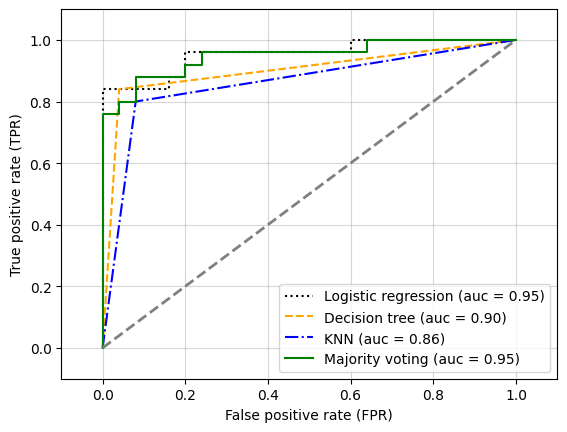

In [5]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
# Loop over classifiers, names, and plot parameters
for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1 ----------->
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    
    # ROC curves for test data for each classifier
    [fpr, tpr, thresholds] = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

### Decision regions

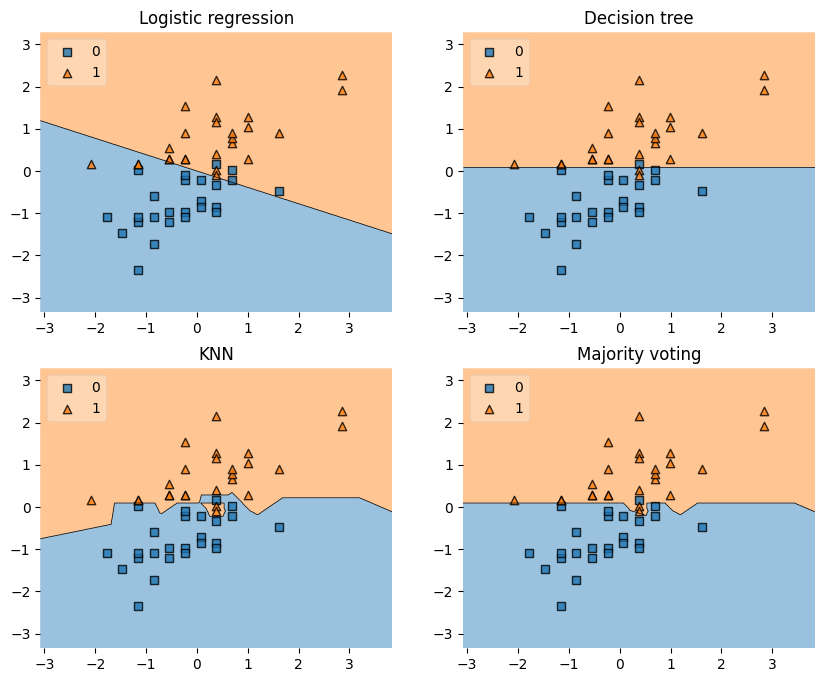

In [6]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))

for clf, lab, grd in zip(all_clf,
                         clf_labels,
                         itertools.product([0, 1], repeat=2)):
    clf.fit(X_train_std, y_train)

    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_std, y=y_train, clf=clf, legend=2)
    plt.title(lab)

plt.show()

As expected, the decision regions of the ensemble classifier
looks like a hybrid of the decision regions from the individual classifiers. At first
glance, the majority vote decision boundary looks a lot like the decision of the
decision tree stump, which is orthogonal to the $y$ axis for sepal width $\geq 1$. However,
it can be noticed that some non-linear parts of the $k$-nearest neighbor decision boundary are mixed into majority vote decision boundary.

### We can get a view of the parameter settings using the get_params
This is needed when we are going to tune individual parameters (rembember svc__C and such)

In [7]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

### Tuning within the ensemble
We can also try to tune the decision tree's max depth (1 or 2) and the inverse regularization
parameter C (0.01, 0.1, 1.0, 10.0 or 100.0) of the logistic regression classifier.

In [8]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.01, 0.1, 1, 10.0, 100.0]}

grid = GridSearchCV(estimator  = mv_clf,
                    param_grid = params,
                    cv         = 10,
                    scoring    = 'roc_auc')
grid.fit(X_train, y_train)

# Inspect AUC of parameter grid combinations
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.01}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 10.0}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.01}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 10.0}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [9]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.01}
Accuracy: 0.98


### Grid Search reminder
The default setting for refit in GridSearchCV is __True__ (i.e., GridSeachCV(..., refit=True)), which means that we can use the fitted GridSearchCV estimator to make predictions via the predict method as follows:

    grid = GridSearchCV(estimator=mv_clf, 
                        param_grid=params, 
                        cv=10,
                        scoring='roc_auc')
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

In addition, the "best" estimator can directly be accessed via the best_estimator_attribute of the grid object.

In [10]:
grid.best_estimator_.classifiers

[Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.01, random_state=1)]]),
 DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]])]

In [11]:
# Update ensemble with best model and parameters according to CV AUC.
mv_clf = grid.best_estimator_
mv_clf.set_params(**grid.best_estimator_.get_params()) 
# Double star passes get_params() as a single dictionary to set_params().

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.01,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

In [12]:
# Full printout
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ('clf', LogisticRegression(C=0.01, random_state=1))]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ('clf', KNeighborsClassifier(n_neighbors=1))]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ('clf', LogisticRegression(C=0.01, random_state=1))],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.01, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.01,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__multi